# Herron Topic 4 - Portfolio Optimization

This notebook covers portfolio optimization.
I have not found a perfect reference that combines portfolio optimization and Python, but here are two references that I find useful:

1. Ivo Welch discusses the mathematics and finance of portfolio optimization in [Chapter 12 of his draft textbook on investments](https://book.ivo-welch.info/bookg.pdf#chapter.12).
1. Eryk Lewinson provides Python code for portfolio optimization in chapter 7 of his [*Python for Finance Cookbook*](https://onesearch.library.northeastern.edu/permalink/01NEU_INST/i2gqis/alma9952082522901401), but he uses several packages that are either non-free or abandoned.

In this notebook, we will:

1. Review the $\frac{1}{n}$ portfolio (or equal-weighted portfolio) from [Herron Topic 1](herron_01_lecture.ipynb)
1. Use SciPy's `minimize()` function to:
    1. Find the minimum variance portfolio
    1. Find the (mean-variance) efficient frontier

In the practice notebook, we will use SciPy's `minimize()` function to achieve any objective.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

## The $\frac{1}{n}$ Portfolio

We first saw the $\frac{1}{n}$ portfolio (or equal-weighted portfolio) in [Herron Topic 1](herron_01_lecture.ipynb).
In the $\frac{1}{n}$ portfolio, each of $n$ assets receives an equal portfolio weight $w_i = \frac{1}{n}$.
While the $\frac{1}{n}$ strategy seems too simple to be useful, DeMiguel, Garlappi, and Uppal (2007) show that it is difficult to beat $\frac{1}{n}$ strategy, even with more advanced strategies.

In [4]:
tickers = 'MSFT AAPL TSLA AMZN NVDA GOOG'

matana = (
    yf.download(tickers=tickers, progress=False)
    .assign(Date=lambda x: x.index.tz_localize(None))
    .set_index('Date')
    .rename_axis(columns=['Variable', 'Ticker'])
)

matana.tail()

Variable   Adj Close                                                 Close  \
Ticker          AAPL     AMZN     GOOG     MSFT     NVDA     TSLA     AAPL   
Date                                                                         
2023-03-20  157.4000  97.7100 101.9300 272.2300 259.0000 183.2500 157.4000   
2023-03-21  159.2800 100.6100 105.8400 273.7800 261.9900 197.5800 159.2800   
2023-03-22  157.8300  98.7000 104.2200 272.2900 264.6800 191.1500 157.8300   
2023-03-23  158.9300  98.7100 106.2600 277.6600 271.9100 192.2200 158.9300   
2023-03-24  158.9300  97.4100 105.6050 278.5400 266.2550 189.4000 158.9300   

Variable                               ...     Open                    \
Ticker         AMZN     GOOG     MSFT  ...     GOOG     MSFT     NVDA   
Date                                   ...                              
2023-03-20  97.7100 101.9300 272.2300  ... 101.0600 276.9800 256.1500   
2023-03-21 100.6100 105.8400 273.7800  ... 101.9800 274.8800 261.8000   
2023-03-22  98.7000 104.2200 272.2900  ... 105.1400 273.4000 264.2500   
2023-03-23  98.7100 106.2600 277.6600  ... 105.8900 277.9400 271.1500   
2023-03-24  97.4100 105.6050 278.5400  ... 105.7400 277.2400 270.3100   

Variable               Volume                                            \
Ticker         TSLA      AAPL          AMZN          GOOG          MSFT   
Date                                                                      
2023-03-20 178.0800  73641400 62388900.0000 26033900.0000 43466600.0000   
2023-03-21 188.2800  73938300 58597300.0000 33122800.0000 34558700.0000   
2023-03-22 199.3000  75701800 57475400.0000 32336900.0000 34873300.0000   
2023-03-23 195.2600  67572500 57491000.0000 31369800.0000 36590300.0000   
2023-03-24 191.6500  26073408 26008374.0000 12005487.0000 12500555.0000   

Variable                                 
Ticker              NVDA           TSLA  
Date                                     
2023-03-20 43274700.0000 129684400.0000  
2023-03-21 54740800.0000 153391400.0000  
2023-03-22 79729500.0000 150376400.0000  
2023-03-23 56377300.0000 143865300.0000  
2023-03-24 24673779.0000  63328036.0000  

[5 rows x 36 columns]

In [5]:
returns = matana['Adj Close'].pct_change().iloc[(-3 * 252):]

returns.describe()

Ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
count,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000
mean,0.0015,0.0003,0.0010,0.0011,0.0025,0.0032
std,0.0206,0.0243,0.0207,0.0191,0.0334,0.0421
min,-0.0801,-0.1405,-0.0963,-0.0772,-0.0947,-0.2106
25%,-0.0101,-0.0132,-0.0097,-0.0096,-0.0172,-0.0208
50%,0.0012,0.0005,0.0015,0.0007,0.0032,0.0021
75%,0.0141,0.0127,0.0117,0.0120,0.0230,0.0251
max,0.1047,0.1354,0.0874,0.0823,0.1433,0.1964


Before we revisit the advanced techniques from [Herron Topic 1](herron_01_lecture), we can calculate $\frac{1}{n}$ portfolio returns manually, where $R_P = \frac{\sum_{i}^{n} R_i}{n}$
Since our weights are constant (i.e., do not change over time), we rebalance our portfolio every return period.
If we have daily data, rebalance daily.
If we have monthly data, we rebalance monthly, and so on.

In [6]:
n = returns.shape[1]
p1 = returns.sum(axis=1).div(n)

p1.describe()

count   756.0000
mean      0.0016
std       0.0218
min      -0.0782
25%      -0.0113
50%       0.0021
75%       0.0149
max       0.0980
dtype: float64

Recall from [Herron Topic 1](herron_01_lecture) we have two better options:

1. The `.mean(axis=1)` method for the $\frac{1}{n}$ portfolio
1. The `.dot(weights)` method where `weights` is a pandas series or NumPy array of portfolio weights, allowing different weights for each asset

In [7]:
p2 = returns.mean(axis=1)

p2.describe()

count   756.0000
mean      0.0016
std       0.0218
min      -0.0782
25%      -0.0113
50%       0.0021
75%       0.0149
max       0.0980
dtype: float64

In [8]:
weights = np.ones(n) / n
p3 = returns.dot(weights)

p3.describe()

count   756.0000
mean      0.0016
std       0.0218
min      -0.0782
25%      -0.0113
50%       0.0021
75%       0.0149
max       0.0980
dtype: float64

The `.describe()` method provides summary statistics for data, letting us make quick comparisons.
However, we should use `np.allclose()` if we want to be sure that `p1`, `p2`, and `p3` are similar.

In [9]:
np.allclose(p1, p2)

True

In [10]:
np.allclose(p1, p3)

True

---

Here is a simple example to help understand the `.dot()` method.

In [11]:
silly_n = 3
silly_R = pd.DataFrame(np.arange(2*silly_n).reshape(2, silly_n))
silly_w = np.ones(3) / 3

In [12]:
print(
    f'silly_n:\n{silly_n}',
    f'silly_R:\n{silly_R}',
    f'silly_w:\n{silly_w}',
    sep='\n\n'
)

silly_n:
3

silly_R:
   0  1  2
0  0  1  2
1  3  4  5

silly_w:
[0.3333 0.3333 0.3333]


In [13]:
silly_R.dot(silly_w)

0   1.0000
1   4.0000
dtype: float64

Under the hood, Python and the `.dot()` method (effectively) do the following calculation:

In [14]:
for i, row in silly_R.iterrows():
    print(
        f'Row {i}: ',
        ' + '.join([f'{w:0.2f} * {y}' for w, y in zip(silly_w, row)]),
        ' = ',
        f'{silly_R.dot(silly_w).iloc[i]:0.2f}'
    )

Row 0:  0.33 * 0 + 0.33 * 1 + 0.33 * 2  =  1.00
Row 1:  0.33 * 3 + 0.33 * 4 + 0.33 * 5  =  4.00


---

## SciPy's `minimize()` Function 

### A Crash Course in SciPy's `minimize()` Function

The `minimize()` function from SciPy's `optimize` module finds the input array `x` that minimizes the output of the function `fun`.
The `minimize()` function uses optimization techniques that are outside this course, but you can consider these optimization techniques to be sophisticated trial and error.

Here are the most common arguments we will pass to the `minimize()` function:

1. We pass our first guess for input array `x` to argument `x0=`.
1. We pass additional arguments for function `fun` as a tuple to argument `args=`.
1. We pass lower and upper bounds on `x` as a tuple of tuples to argument `bounds=`.
1. We constrain our results with a tuple of dictionaries of functions to argument `contraints=`.

Here is a simple example that minimizes the function `quadratic()` that accepts arguments `x` and `a` and returns $y = (x - a)^2$.

In [15]:
import scipy.optimize as sco

In [16]:
def quadratic(x, a=5):
    return (x - a) ** 2

In [17]:
quadratic(x=5, a=5)

0

In [18]:
quadratic(x=10, a=5)

25

It is helpful to plot $y = (x - a)$ first.

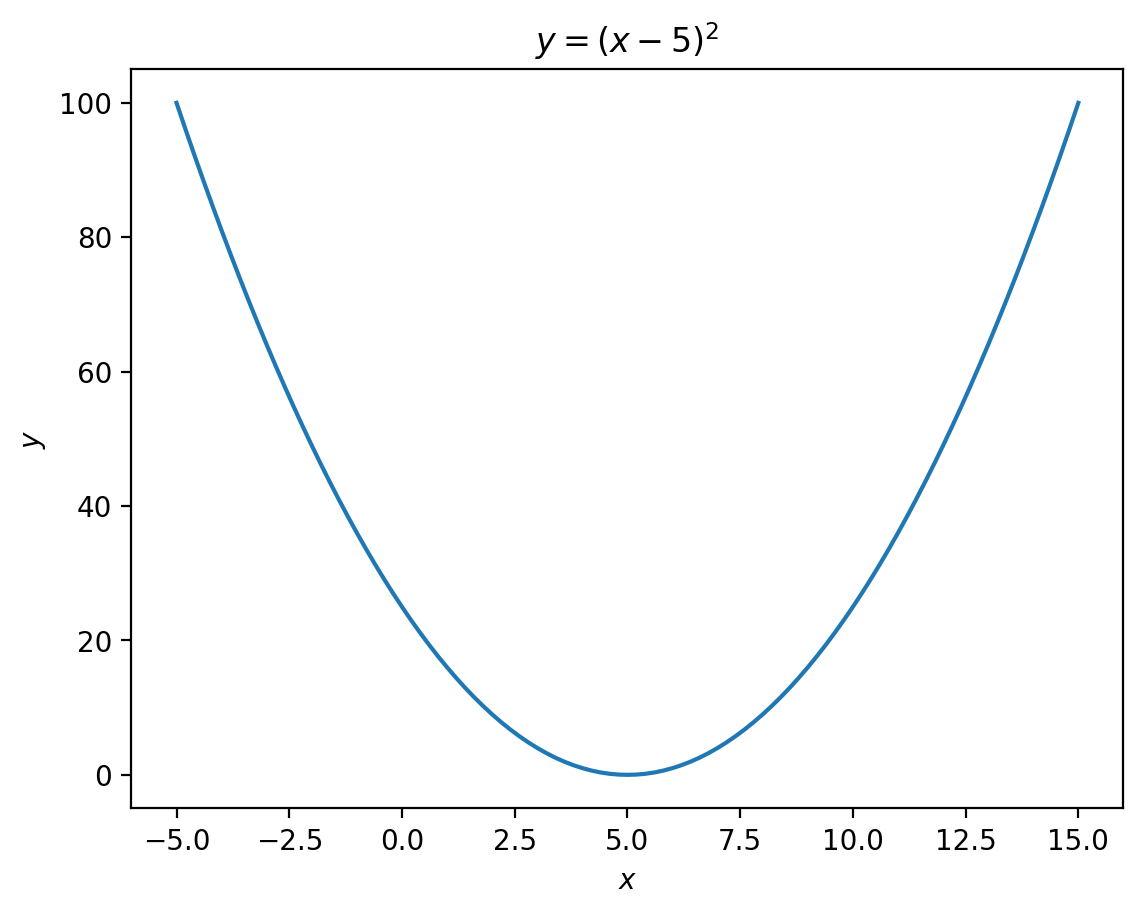

In [19]:
x = np.linspace(-5, 15, 101)
y = quadratic(x=x)
plt.plot(x, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$y = (x - 5)^2$')
plt.show()

The minimum output of `quadratic()` occurs at $x=5$ if we do not use bounds or constraints, even if we start far away from $x=5$.

In [20]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001])
)

      fun: 2.0392713450495178e-16
 hess_inv: array([[0.5]])
      jac: array([-1.3659e-08])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([5.])

The minimum output of `quadratic()` occurs at $x=6$ if we bound `x` between 6 and 10 (i.e., $6 \leq x \leq 10$).

In [21]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001]),
    bounds=((6, 10),)
)

      fun: 1.0
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([6.])

The minimum output of `quadratic()` occurs at $x=6$, again, if we constrain `x - 6` to be non-negative.
We use bounds to limit the search space directly, and we use constraints to limit the search space indirectly based on a formula.

In [22]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001]),
    constraints=({'type': 'ineq', 'fun': lambda x: x - 6})
)

     fun: 1.0000000000000018
     jac: array([2.])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([6.])

We can use the `args=` argument to pass additional arguments to `fun`.
For example, we change the `a=` argument in `quadratic()` from the default of `a=5` to `a=20` with `args=(20,)`.
Note that `args=` expects a tuple, so we need a trailing comma `,` if we have one argument.

In [24]:
sco.minimize(
    fun=quadratic,
    args=(20,),
    x0=np.array([2001]),
)

      fun: 7.090392030754976e-17
 hess_inv: array([[0.5]])
      jac: array([-1.9397e-09])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([20.])

### The Minimum Variance Portfolio

We can find the minimum variance portfolio with `minimize()` function from SciPy's `optimize` module.
The `minimize()` function with vary an input array `x` (starting from argument `x0=`) to minimize the objective function `fun=` subject to the bounds and constraints in `bounds=` and `constraints=`. 
We will define a function `port_vol()` to calculate portfolio volatility.
The first argument to `port_vol()` must be the input array `x` that the `minimize()` function searches over.
For clarity, we will call this first argument `x`, but the argument's name is not important.

In [25]:
def port_vol(x, r, ppy):
    return np.sqrt(ppy) * r.dot(x).std()

We will eventually need a mean portfolio return function, too.

In [26]:
def port_mean(x, r, ppy):
    return ppy * r.dot(x).mean()

In [28]:
res_mv = sco.minimize(
    fun=port_vol, # objective function that we minimize
    x0=np.ones(returns.shape[1]) / returns.shape[1], # initial portfolio weights
    args=(returns, 252), # additional arguments to our objective function
    bounds=[(0,1) for _ in returns], # bounds limit the search space for each portfolio weights
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # minimize drives "eq" constraints to zero
    )
)

print(res_mv)

     fun: 0.28980781598721805
     jac: array([0.2903, 0.29  , 0.2894, 0.2897, 0.397 , 0.3458])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([3.0827e-01, 0.0000e+00, 2.3112e-01, 4.6061e-01, 7.4593e-17,
       0.0000e+00])


What are the attributes of this minimum variance portfolio?

In [29]:
def print_port_res(w, r, title, ppy=252, tgt=None):
    width = len(title)
    rp = r.dot(w)
    mu = ppy * rp.mean()
    sigma = np.sqrt(ppy) * rp.std()
    if tgt is not None:
        er = rp.sub(tgt)
        sr = np.sqrt(ppy) * er.mean() / er.std()
    else:
        sr = None
    
    return print(
        title,
        '=' * width,
        '',
        'Performance',
        '-' * width,
        'Return:'.ljust(width - 6) + f'{mu:0.4f}',
        'Volatility:'.ljust(width - 6) + f'{sigma:0.4f}',
        'Sharpe Ratio:'.ljust(width - 6) + f'{sr:0.4f}\n' if sr is not None else '',
        'Weights', 
        '-' * width, 
        '\n'.join([f'{_r}:'.ljust(width - 6) + f'{_w:0.4f}' for _r, _w in zip(r.columns, w)]),
        sep='\n',
    )

In [31]:
print_port_res(w=res_mv['x'], r=returns, title='Minimum Variance Portfolio')

Minimum Variance Portfolio

Performance
--------------------------
Return:             0.2984
Volatility:         0.2898

Weights
--------------------------
AAPL:               0.3083
AMZN:               0.0000
GOOG:               0.2311
MSFT:               0.4606
NVDA:               0.0000
TSLA:               0.0000


### The (Mean-Variance) Efficient Frontier

We will use the `minimize()` function to map the efficient frontier.
Here is a basic outline:

1. Create a NumPy array `tret` of target returns
1. Create an empty list `res_ef` of `minimize()` results
1. Loop over `tret`, passing each as a constraint to the `minimize()` function
1. Append each `minimize()` result to `res_ef`

In [33]:
tret = 252 * np.linspace(returns.mean().min(), returns.mean().max(), 25)

tret

array([0.076 , 0.1061, 0.1362, 0.1663, 0.1964, 0.2266, 0.2567, 0.2868,
       0.3169, 0.347 , 0.3772, 0.4073, 0.4374, 0.4675, 0.4976, 0.5277,
       0.5579, 0.588 , 0.6181, 0.6482, 0.6783, 0.7085, 0.7386, 0.7687,
       0.7988])

We will loop over these target returns, finding the minimum variance portfolio for each target return.

In [34]:
res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol, # minimize portfolio volatility
        x0=np.ones(returns.shape[1]) / returns.shape[1], # initial portfolio weights
        args=(returns, 252), # additional arguments to fun, in order
        bounds=[(0, 1) for c in returns.columns], # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=returns, ppy=252) - t} # constrains portfolio mean return to the target return

        )
    )
    res_ef.append(_)

List `res_ef` contains the results of all 25 minimum-variance portfolios.
For example, `res_ef[0]` is the minimum variance portfolio for the lowest target return.

In [35]:
res_ef[0]

     fun: 0.38644121151979843
     jac: array([0.2148, 0.3864, 0.2244, 0.2158, 0.3411, 0.3183])
 message: 'Optimization terminated successfully'
    nfev: 21
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.0000e+00, 1.0000e+00, 0.0000e+00, 2.9160e-11, 0.0000e+00,
       5.2856e-17])

I typically check that all portfolio volatility minimization succeeds.
If a portfolio volatility minimization fails, we should check our function, bounds, and constraints.

In [36]:
for r in res_ef:
    assert r['success'] 

We can combine the target returns and volatilities into a data frame `ef`.

In [37]:
ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)

ef.head()

,tret,tvol
0,0.0760,0.3864
1,0.1061,0.3609
2,0.1362,0.3388
3,0.1663,0.3207
4,0.1964,0.3073


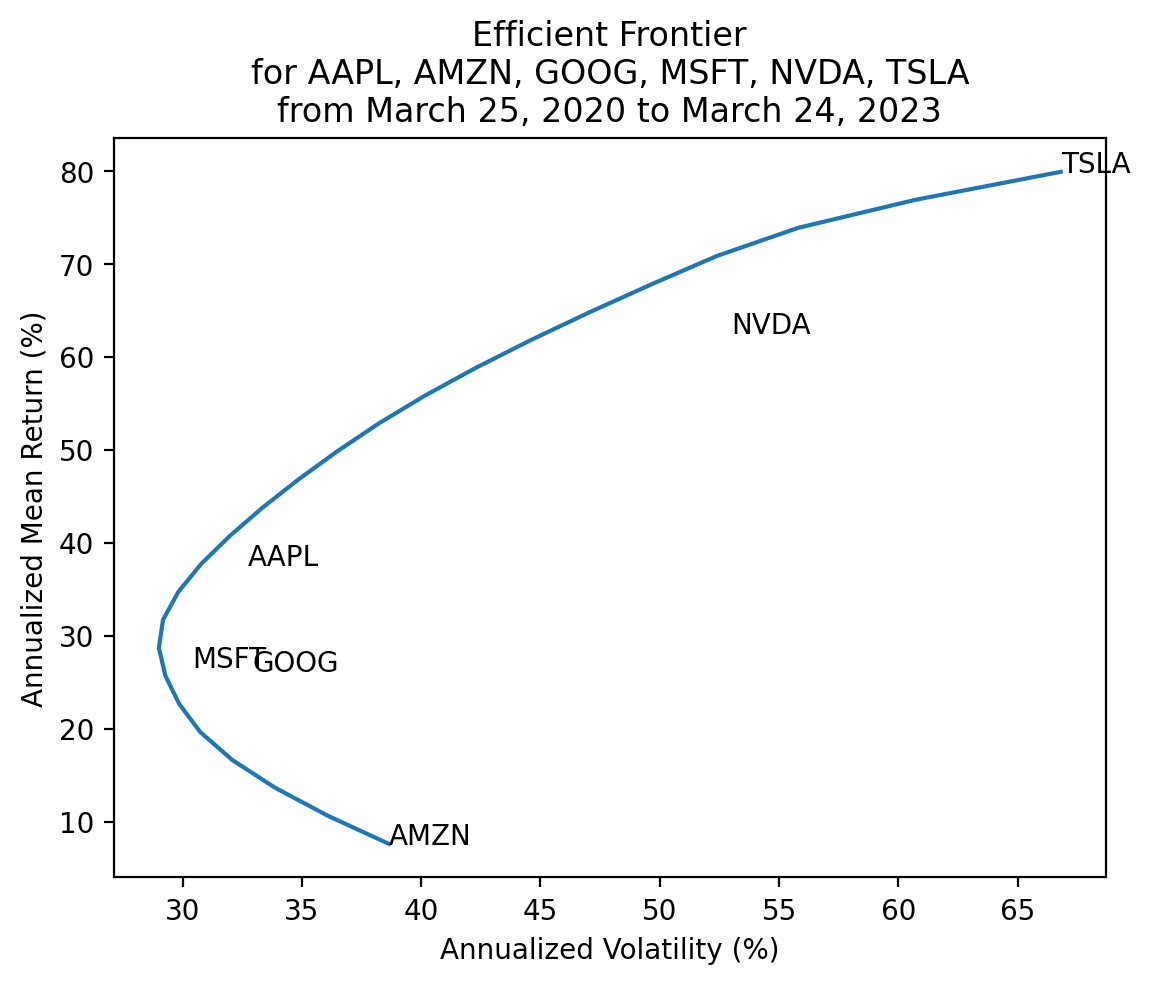

In [39]:
ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title(
    f'Efficient Frontier' +
    f'\nfor {", ".join(returns.columns)}' +
    f'\nfrom {returns.index[0]:%B %d, %Y} to {returns.index[-1]:%B %d, %Y}'
)

for t, x, y in zip(
    returns.columns, 
    returns.std().mul(100*np.sqrt(252)),
    returns.mean().mul(100*252)
):
    plt.annotate(text=t, xy=(x, y))
    
plt.show()